# YOLO (You Only Look Once) Implementation for Traffic Assesment

## Prerequisites

#### Installing python dependencies

In [1]:
!pip install pillow

You should consider upgrading via the 'pip install --upgrade pip' command.


#### Enabling Jupyter autocomplete in Docker

In [2]:
!pip3 install jupyter-tabnine
!jupyter nbextension install --py jupyter_tabnine
!jupyter nbextension enable --py jupyter_tabnine
!jupyter serverextension enable --py jupyter_tabnine

You should consider upgrading via the 'pip install --upgrade pip' command.
Installing /usr/local/lib/python3.6/dist-packages/jupyter_tabnine/static -> jupyter_tabnine
Up to date: /usr/local/share/jupyter/nbextensions/jupyter_tabnine/README.md
Up to date: /usr/local/share/jupyter/nbextensions/jupyter_tabnine/main.css
Up to date: /usr/local/share/jupyter/nbextensions/jupyter_tabnine/tabnine.yaml
Up to date: /usr/local/share/jupyter/nbextensions/jupyter_tabnine/main.js
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable jupyter_tabnine --py
    
Enabling notebook extension jupyter_tabnine/main...
      - Validating: OK
Enabling: jupyter_tabnine
- Writing config: /root/.jupyter
    - Validating...
      jupyter_tabnine  OK


#### Importing libraries

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import matplotlib.patches as patches
import PIL
from PIL import Image

tf.__version__

'2.1.0-dev20191011'

#### Listing available training devices

In [4]:
from tensorflow.python.client import device_lib
[x.name for x in device_lib.list_local_devices()]

['/device:CPU:0', '/device:XLA_CPU:0']

## Loading training/validation datasets

#### Defining a class for the annotated image data

In [15]:
from xml.dom import minidom

class AnnotatedImage:    
    def __init__(self, name):
        self.name = name
        self.filepath = './data/VOCdevkit/VOC2012/JPEGImages/' + name + '.jpg'
        self.image = Image.open(self.filepath)
        self.objects = self.__get_objects()
        
    def __get_objects(self):
        document = minidom.parse('./data/VOCdevkit/VOC2012/Annotations/' + self.name + '.xml')
        xml_objects = document.getElementsByTagName('object')
        parsed_objects = []
        for xml_object in xml_objects:
            xml_bbox = xml_object.getElementsByTagName('bndbox')[0]
            min_x = int(xml_bbox.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            min_y = int(xml_bbox.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            max_x = int(xml_bbox.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            max_y = int(xml_bbox.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            
            parsed_objects.append({
                'name': xml_object.getElementsByTagName('name')[0].firstChild.nodeValue,
                'truncated': xml_object.getElementsByTagName('truncated')[0].firstChild.nodeValue == 1,
                'difficult': xml_object.getElementsByTagName('difficult')[0].firstChild.nodeValue == 1,
                'bbox': {
                    "min": (
                        int(min_x * (416 / self.image.size[0])),
                        int(min_y * (416 / self.image.size[1]))
                    ),
                    "max": (
                        int(max_x * (416 / self.image.size[0])),
                        int(max_y * (416 / self.image.size[1]))
                    )
                }
            })
        return parsed_objects

#### Defining images with which labels to be loaded

In [6]:
lables_to_load = [
    'bicycle',
    'bus',
    'car',
    'horse',
    'motorbike',
    'person',
    'train'
]

#### Getting a list of all the train/val images of cars

In [7]:
# Loading all the filepaths in a list
train_images_to_load = []
val_images_to_load = []

for lable in lables_to_load:
    train_file = open('./data/VOCdevkit/VOC2012/ImageSets/Main/' + lable + "_train.txt", 'r')
    val_file = open('./data/VOCdevkit/VOC2012/ImageSets/Main/' + lable + "_val.txt", 'r')
    for line in train_file:
        train_images_to_load.append(line[:-4])
    for line in val_file:
        val_images_to_load.append(line[:-4])
    
# Removing duplicate filepaths
train_images_to_load = list(dict.fromkeys(train_images_to_load))
val_images_to_load = list(dict.fromkeys(val_images_to_load))

'Number of images to be loaded: train - {}, val - {}'.format(len(train_images_to_load), len(val_images_to_load))

'Number of images to be loaded: train - 5717, val - 5823'

#### Loading the train/val images into separate array

In [8]:
train_image_list = []
val_image_list = []

for filename in train_images_to_load:
    train_image_list.append(AnnotatedImage(filename))
    
for filename in val_images_to_load:
    val_image_list.append(AnnotatedImage(filename))

#### Removing lables which are not going to be used

In [9]:
for image in train_image_list:
    image.objects = list(filter(lambda x : not(x['name'] not in lables_to_load), image.objects))
    
for image in val_image_list:
    image.objects = list(filter(lambda x : not(x['name'] not in lables_to_load), image.objects))

#### Resizing the images for a consistent model input shape

In [10]:
for image in train_image_list:
    image.image = image.image.resize((416, 416), Image.ANTIALIAS)
    
for image in test_image_list:
    image.image = image.image.resize((416, 416), Image.ANTIALIAS)

#### Testing whether the images & objects are loaded properly

./data/VOCdevkit/VOC2012/JPEGImages/2008_006004.jpg
[]


<Figure size 432x288 with 0 Axes>

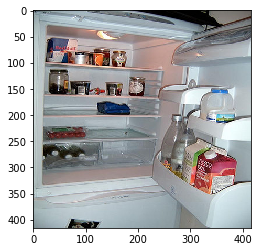

./data/VOCdevkit/VOC2012/JPEGImages/2009_002685.jpg
[]


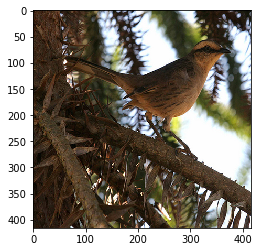

./data/VOCdevkit/VOC2012/JPEGImages/2008_001196.jpg
[{'name': 'car', 'truncated': False, 'difficult': False, 'bbox': {'min': (268, 141), 'max': (416, 260)}}, {'name': 'person', 'truncated': False, 'difficult': False, 'bbox': {'min': (146, 183), 'max': (162, 269)}}, {'name': 'person', 'truncated': False, 'difficult': False, 'bbox': {'min': (164, 187), 'max': (183, 265)}}]


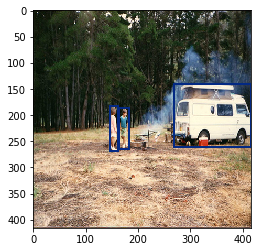

./data/VOCdevkit/VOC2012/JPEGImages/2010_004412.jpg
[{'name': 'train', 'truncated': False, 'difficult': False, 'bbox': {'min': (0, 146), 'max': (361, 368)}}]


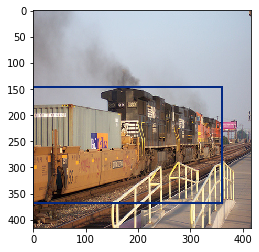

./data/VOCdevkit/VOC2012/JPEGImages/2008_005519.jpg
[{'name': 'person', 'truncated': False, 'difficult': False, 'bbox': {'min': (323, 22), 'max': (384, 221)}}, {'name': 'person', 'truncated': False, 'difficult': False, 'bbox': {'min': (241, 66), 'max': (312, 178)}}, {'name': 'person', 'truncated': False, 'difficult': False, 'bbox': {'min': (275, 69), 'max': (307, 158)}}]


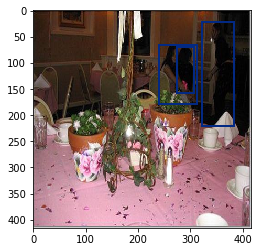

In [14]:
import random

plt.figure()
for i in range(0, 5):
    rng = random.randint(1, len(train_image_list))
    fig,ax = plt.subplots(1)
    ax.imshow(train_image_list[rng].image)
    
    for object in train_image_list[rng].objects:
        rect = patches.Rectangle(
            object['bbox']['min'],
            object['bbox']['max'][0] - object['bbox']['min'][0],
            object['bbox']['max'][1] - object['bbox']['min'][1],
            linewidth=2,
            edgecolor='#032983',
            facecolor='none'
        )
        ax.add_patch(rect)
        
    print(train_image_list[rng].filepath)
    print(train_image_list[rng].objects)
    plt.show()